In [1]:
import os
from dotenv import load_dotenv

load_dotenv()

os.environ["GROQ_API_KEY"] = os.getenv("GROQ_API_KEY")
os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY")

In [9]:
from langchain_openai import ChatOpenAI

def multiply(a:int,b:int)->int:
    """ 
    Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a*b

def add(a:int,b:int)->int:
    """ 
    Add a and b.

    Args:
        a: first int
        b: second int
    """
    return a + b

def divide(a:int,b:int)->float:
    """ 
    Divide a and b.

    Args:
        a: first int
        b: second int
    """
    return a / b

tools = [add,multiply,divide]

llm = ChatOpenAI(model="gpt-4o")

llm_with_tools = llm.bind_tools(tools,parallel_tool_calls=False)

In [10]:
from typing_extensions import TypedDict
from langchain_core.messages import AnyMessage
from typing import Annotated
from langgraph.graph.message import add_messages

class MessageState(TypedDict):
    messages: Annotated[list[AnyMessage],add_messages]

In [11]:
from langchain_core.messages import SystemMessage,HumanMessage

sys_msg = SystemMessage(content="You are a helpful assistant tasked with performing arithmetic on a set of inputs.")

def assistant(state:MessageState):
    return {"messages": [llm_with_tools.invoke([sys_msg]+state["messages"])]}

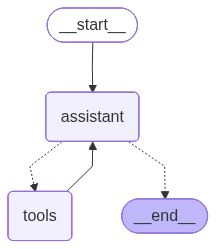

In [12]:
from langgraph.graph import START,StateGraph,END
from langgraph.prebuilt import tools_condition,ToolNode
from IPython.display import Image,display

builder = StateGraph(MessageState)

# Define the Node
builder.add_node("assistant",assistant)
builder.add_node("tools",ToolNode(tools))

# Define the Edges
builder.add_edge(START,"assistant")
builder.add_conditional_edges(
    "assistant",
    tools_condition
)

builder.add_edge("tools","assistant")


react_graph = builder.compile()

display(Image(react_graph.get_graph().draw_mermaid_png()))

In [14]:
messages = [HumanMessage(content="Add 10 and 14. Multiply the output by 2. Divide the output by 5")]
result = react_graph.invoke({"messages": messages})

for m in result["messages"]:
    m.pretty_print()

================================ Human Message =================================

Add 10 and 14. Multiply the output by 2. Divide the output by 5
================================== Ai Message ==================================
Tool Calls:
  add (call_LKBZt2DOy30XB5um4IOZMAKM)
 Call ID: call_LKBZt2DOy30XB5um4IOZMAKM
  Args:
    a: 10
    b: 14
================================= Tool Message =================================
Name: add

24
================================== Ai Message ==================================
Tool Calls:
  multiply (call_TVUuN8FbpSMAk4EigH6BLPX3)
 Call ID: call_TVUuN8FbpSMAk4EigH6BLPX3
  Args:
    a: 24
    b: 2
================================= Tool Message =================================
Name: multiply

48
================================== Ai Message ==================================
Tool Calls:
  divide (call_iljMxdJbvN8x2DxiZXcwuRfZ)
 Call ID: call_iljMxdJbvN8x2DxiZXcwuRfZ
  Args:
    a: 48
    b: 5
================================= Tool Message =========

### Memory in Agents using MemorySaver

In [15]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

react_graph = builder.compile(checkpointer=memory)

In [16]:
config = {"configurable":{"thread_id":"1"}}

messages = [HumanMessage(content="Add 3 and 4")]

messages = react_graph.invoke({"messages":messages},config)

for m in messages["messages"]:
    m.pretty_print()

================================ Human Message =================================

Add 3 and 4
================================== Ai Message ==================================
Tool Calls:
  add (call_YIXfSN2xm4eDaDCrI5hgYzrf)
 Call ID: call_YIXfSN2xm4eDaDCrI5hgYzrf
  Args:
    a: 3
    b: 4
================================= Tool Message =================================
Name: add

7
================================== Ai Message ==================================

The sum of 3 and 4 is 7.


In [17]:
messages = [HumanMessage(content="Multiply that by 2")]

messages = react_graph.invoke({"messages":messages},config)

for m in messages["messages"]:
    m.pretty_print()

================================ Human Message =================================

Add 3 and 4
================================== Ai Message ==================================
Tool Calls:
  add (call_YIXfSN2xm4eDaDCrI5hgYzrf)
 Call ID: call_YIXfSN2xm4eDaDCrI5hgYzrf
  Args:
    a: 3
    b: 4
================================= Tool Message =================================
Name: add

7
================================== Ai Message ==================================

The sum of 3 and 4 is 7.
================================ Human Message =================================

Multiply that by 2
================================== Ai Message ==================================
Tool Calls:
  multiply (call_qS70eV4u09AnTPv0lNApGUMl)
 Call ID: call_qS70eV4u09AnTPv0lNApGUMl
  Args:
    a: 7
    b: 2
================================= Tool Message =================================
Name: multiply

14
================================== Ai Message ==================================

Multiplying 7 by 2 give